In [87]:
# append sscode to path
import sys, os
sys.path.insert(0,'/Users/administrador/Documents/geocean-nz-ss')
data_path = '/Volumes/ToshibaJT/geocean-nz-ss/data'
os.environ["SSURGE_DATA_PATH"] = data_path
from sscode.config import default_region_reduced
from sscode.data import Loader
from sscode.pca import PCA_DynamicPred

import xarray as xr
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RegressionModel, TCNModel, BlockRNNModel
from darts.metrics import r2_score, rmse

In [6]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc'], plot=(False,False,False),
    load_predictor_files=(True,
        [data_path+'/cfsr/CFSR_MSLP_daily.nc',data_path+'/cfsr/CFSR_WINDs_daily.nc']
    ) # load previously calculated winds
)


 loading previously saved atmospheric data from ['/Volumes/ToshibaJT/geocean-nz-ss/data/cfsr/CFSR_MSLP_daily.nc', '/Volumes/ToshibaJT/geocean-nz-ss/data/cfsr/CFSR_WINDs_daily.nc'] 


 loading the Moana v2 hindcast data... 


 loading the UHSLC tidal guages... 



In [88]:
# create dart TimeSeries
clos_to_uhslc = [689,328,393,1327,393,480,999,116,224,1124,949,708]
ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=clos_to_uhslc)\
    .load().resample(time='1D').max().dropna(dim='time')

/Volumes/ToshibaJT/geocean-nz-ss/data/pcs_to_seb/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Volumes/ToshibaJT/geocean-nz-ss/data/pcs_to_seb/default_region_reduced_no_winds_gradients_1D_tl1.nc
Assembling matrix
Start 32512


sh: free: command not found



 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (11354, 45, 51) 


 calculating PCs matrix with shape: 
 (11353, 4590) 

Computing using CPU
matrix (11353, 4590)
PCs (11353, 4590)
comp (4590, 4590)
var (4590,)
lon <xarray.DataArray 'longitude' (longitude: 51)>
array([160. , 160.5, 161. , 161.5, 162. , 162.5, 163. , 163.5, 164. , 164.5,
       165. , 165.5, 166. , 166.5, 167. , 167.5, 168. , 168.5, 169. , 169.5,
       170. , 170.5, 171. , 171.5, 172. , 172.5, 173. , 173.5, 174. , 174.5,
       175. , 175.5, 176. , 176.5, 177. , 177.5, 178. , 178.5, 179. , 179.5,
       180. , 180.5, 181. , 181.5, 182. , 182.5, 183. , 183.5, 184. , 184.5,
       185. ], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 160.0 160.5 161.0 161.5 ... 184.0 184.5 185.0
lat <xarray.DataArray 'latitude' (latitude: 45)>
array([-52. , -51.5, -51. , -50.5, -50. , -49.5, -49. , -48.5, -48. , -47.5,
       -47. , -46.5, -46. , -45.5, -45

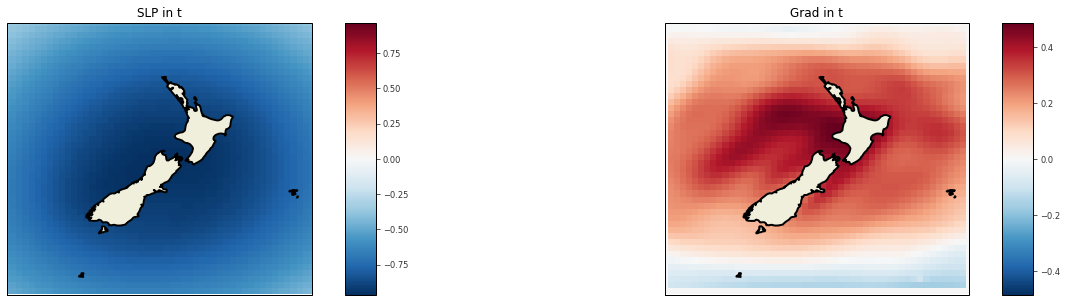

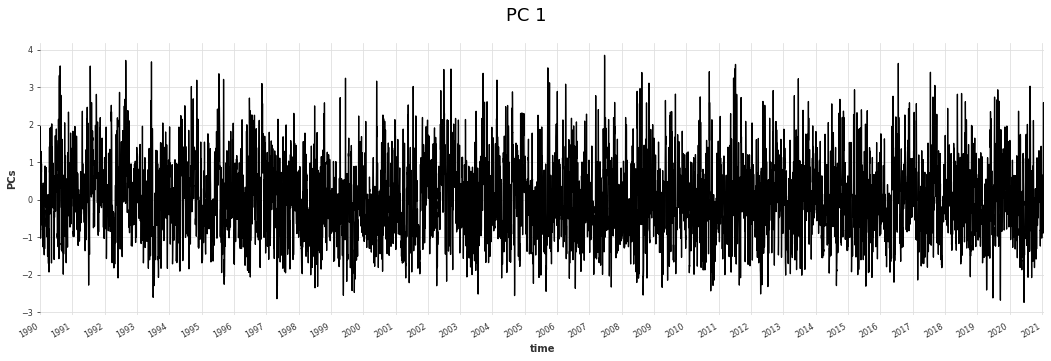

In [93]:
covariates = PCA_DynamicPred(
    load_cfsr_moana_uhslc.predictor_slp.SLP, 
    calculate_gradient=True, time_lapse=1,
    # wind=load_cfsr_moana_uhslc.predictor_wind,
    # site_location=(ss_moana.lon.values[0],ss_moana.lat.values[0]),
    # region=(True, (
    #     ss_moana.lon.values[0]-2.5,
    #     ss_moana.lon.values[0]+2.5,
    #     ss_moana.lat.values[0]-2.5,
    #     ss_moana.lat.values[0]+2.5
    # )),
    # site_id=393,
    region=(True,default_region_reduced),
    pcs_folder=data_path+'/pcs_to_seb/',
    pca_plot=(True,False,1), verbose=True,
    pca_ttls=['SLP in t','Grad in t']
).pcs_get()[0]

In [98]:
ss_moana_darts = TimeSeries.from_xarray(
    ss_moana.ss.rename({'site':'component'}).expand_dims('sample')\
        .transpose('time','component','sample'),
    freq='1D'
)
covariates_darts = TimeSeries.from_xarray(
    covariates.PCs.fillna(0.0)\
        .isel(n_components=slice(0,40))\
        .sel(time=ss_moana.time)\
        .rename({'n_components':'component'}).expand_dims('sample')\
        .transpose('time','component','sample'),
    freq='1D'
)

[2022-02-10 14:02:33,727] WARNING | darts.timeseries | Number of components is larger than 10 (12). Plotting only the first 10 components.


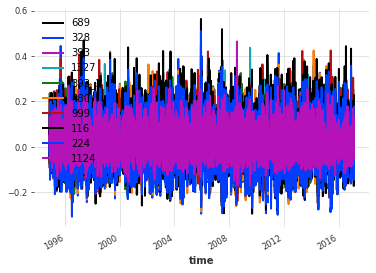

In [99]:
ss_moana_darts.plot()

[2022-02-10 14:02:37,538] WARNING | darts.timeseries | Number of components is larger than 10 (40). Plotting only the first 10 components.


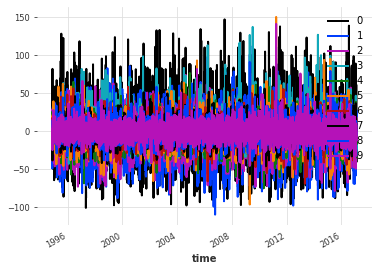

In [100]:
covariates_darts.plot()

In [101]:
# fit the model
model = RegressionModel(lags_past_covariates=10)
model.fit(ss_moana_darts,
          past_covariates=covariates_darts
)

In [102]:
backtest = model.historical_forecasts(
    series=ss_moana_darts,
    past_covariates=covariates_darts,
    start=0.9,
    retrain=False,
    verbose=True,
    forecast_horizon=1
)

  0%|          | 0/814 [00:00<?, ?it/s]

[2022-02-10 14:02:55,245] WARNING | darts.timeseries | Number of components is larger than 10 (12). Plotting only the first 10 components.
[2022-02-10 14:02:55,353] WARNING | darts.timeseries | Number of components is larger than 10 (12). Plotting only the first 10 components.


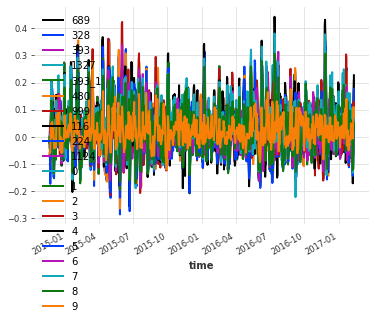

In [103]:
ss_moana_darts.split_after(0.9)[1].plot()
backtest.plot()

In [104]:
rmse(ss_moana_darts,backtest), r2_score(ss_moana_darts,backtest)

(0.04516490081676484, 0.6795157463027782)

In [105]:
# fit the NN model
modelNN = BlockRNNModel(model='LSTM',
                        input_chunk_length=10,
                        output_chunk_length=1,
                        n_epochs=10
)
modelNN.fit(
    series=ss_moana_darts.split_before(0.2)[0],
    past_covariates=covariates_darts.split_before(0.2)[0],
    val_series=ss_moana_darts.split_after(0.7)[1],
    val_past_covariates=covariates_darts.split_after(0.7)[1],
    verbose=True,
    
)

[2022-02-10 14:03:21,018] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1615 samples.
[2022-02-10 14:03:21,018] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1615 samples.
[2022-02-10 14:03:21,025] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-10 14:03:21,025] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/10 [00:00<?, ?it/s]

In [106]:
backtest = modelNN.historical_forecasts(
    series=ss_moana_darts,
    past_covariates=covariates_darts,
    start=0.95,
    forecast_horizon=1,
    retrain=False,
    verbose=True
)

  0%|          | 0/408 [00:00<?, ?it/s]

[2022-02-10 14:03:33,522] WARNING | darts.timeseries | Number of components is larger than 10 (12). Plotting only the first 10 components.
[2022-02-10 14:03:33,616] WARNING | darts.timeseries | Number of components is larger than 10 (12). Plotting only the first 10 components.


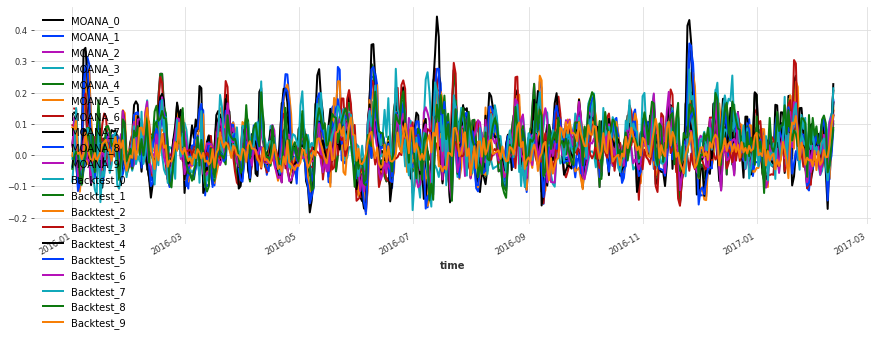

In [107]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
ss_moana_darts.split_after(0.95)[1].plot(label='MOANA')
backtest.plot(label='Backtest')
plt.legend()

<AxesSubplot:xlabel='time'>

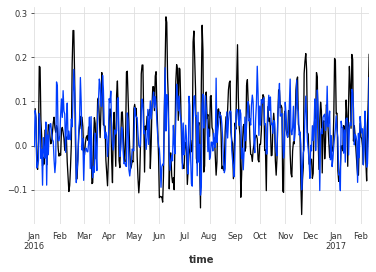

In [122]:
ss_moana_darts.split_after(0.95)[1].pd_dataframe()['393'].plot()
backtest.pd_dataframe()['2'].plot()